# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/DL/dlcourse_ai/assignments/assignment2/'

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DL/dlcourse_ai/assignments/assignment2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [ ]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [ ]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [ ]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [ ]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [ ]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [ ]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [ ]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 2.364764, Train accuracy: 0.223889, val accuracy: 0.233000
Epoch: 1, Loss: 2.318168, Train accuracy: 0.278111, val accuracy: 0.293000
Epoch: 2, Loss: 1.981519, Train accuracy: 0.329333, val accuracy: 0.344000
Epoch: 3, Loss: 2.007584, Train accuracy: 0.412222, val accuracy: 0.420000
Epoch: 4, Loss: 1.703306, Train accuracy: 0.479778, val accuracy: 0.475000
Epoch: 5, Loss: 1.729589, Train accuracy: 0.524556, val accuracy: 0.527000
Epoch: 6, Loss: 1.724146, Train accuracy: 0.575667, val accuracy: 0.559000
Epoch: 7, Loss: 1.674380, Train accuracy: 0.606333, val accuracy: 0.593000
Epoch: 8, Loss: 1.588569, Train accuracy: 0.636444, val accuracy: 0.620000
Epoch: 9, Loss: 1.218824, Train accuracy: 0.653667, val accuracy: 0.617000
Epoch: 10, Loss: 1.619584, Train accuracy: 0.662000, val accuracy: 0.639000
Epoch: 11, Loss: 1.511976, Train accuracy: 0.675000, val accuracy: 0.649000
Epoch: 12, Loss: 0.992522, Train accuracy: 0.685778, val accuracy: 0.666000
Epoch: 13, Loss: 1.438

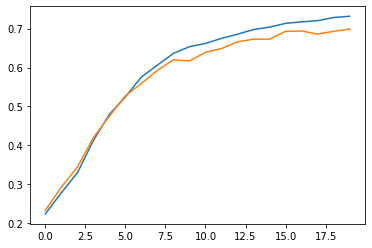

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [ ]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, Loss: 2.397015, Train accuracy: 0.245222, val accuracy: 0.249000
Epoch: 1, Loss: 2.179481, Train accuracy: 0.304667, val accuracy: 0.320000
Epoch: 2, Loss: 1.994234, Train accuracy: 0.373778, val accuracy: 0.381000
Epoch: 3, Loss: 1.634993, Train accuracy: 0.430556, val accuracy: 0.432000
Epoch: 4, Loss: 1.795355, Train accuracy: 0.513556, val accuracy: 0.496000
Epoch: 5, Loss: 1.814152, Train accuracy: 0.553889, val accuracy: 0.550000
Epoch: 6, Loss: 1.711707, Train accuracy: 0.575889, val accuracy: 0.561000
Epoch: 7, Loss: 1.467092, Train accuracy: 0.610667, val accuracy: 0.591000
Epoch: 8, Loss: 1.306622, Train accuracy: 0.630111, val accuracy: 0.615000
Epoch: 9, Loss: 1.424744, Train accuracy: 0.647778, val accuracy: 0.628000
Epoch: 10, Loss: 1.607219, Train accuracy: 0.659444, val accuracy: 0.644000
Epoch: 11, Loss: 1.585350, Train accuracy: 0.674778, val accuracy: 0.662000
Epoch: 12, Loss: 1.257531, Train accuracy: 0.682000, val accuracy: 0.655000
Epoch: 13, Loss: 1.355

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [ ]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 1.476406, Train accuracy: 0.542778, val accuracy: 0.527000
Epoch: 1, Loss: 1.361918, Train accuracy: 0.620556, val accuracy: 0.603000
Epoch: 2, Loss: 1.460362, Train accuracy: 0.671444, val accuracy: 0.653000
Epoch: 3, Loss: 1.356977, Train accuracy: 0.716111, val accuracy: 0.675000
Epoch: 4, Loss: 1.571176, Train accuracy: 0.724000, val accuracy: 0.686000
Epoch: 5, Loss: 1.522191, Train accuracy: 0.734556, val accuracy: 0.666000
Epoch: 6, Loss: 1.083224, Train accuracy: 0.751333, val accuracy: 0.705000
Epoch: 7, Loss: 1.198733, Train accuracy: 0.780000, val accuracy: 0.717000
Epoch: 8, Loss: 0.806278, Train accuracy: 0.774444, val accuracy: 0.707000
Epoch: 9, Loss: 1.126008, Train accuracy: 0.788667, val accuracy: 0.718000
Epoch: 10, Loss: 1.127628, Train accuracy: 0.795000, val accuracy: 0.706000
Epoch: 11, Loss: 0.522356, Train accuracy: 0.796000, val accuracy: 0.714000
Epoch: 12, Loss: 0.817996, Train accuracy: 0.818333, val accuracy: 0.718000
Epoch: 13, Loss: 0.829

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [ ]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 12.437961, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 1, Loss: 10.958966, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 2, Loss: 9.364132, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 3, Loss: 8.215285, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 4, Loss: 7.470739, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 5, Loss: 7.099143, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 6, Loss: 5.828525, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 7, Loss: 6.079210, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 8, Loss: 5.429390, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch: 9, Loss: 5.044803, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 10, Loss: 4.438574, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 11, Loss: 4.254438, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 12, Loss: 3.783138, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 13, Loss: 3.4

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [ ]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs

trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss: 12.528112, Train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 1, Loss: 8.342491, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 2, Loss: 8.239564, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 3, Loss: 7.166631, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 4, Loss: 9.532655, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 5, Loss: 4.242567, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 6, Loss: 2.328529, Train accuracy: 0.800000, val accuracy: 0.000000
Epoch: 7, Loss: 1.863665, Train accuracy: 0.866667, val accuracy: 0.000000
Epoch: 8, Loss: 2.261274, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 9, Loss: 1.854638, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 10, Loss: 1.182552, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 11, Loss: 2.567706, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 12, Loss: 1.725332, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 13, Loss: 1.74

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

batch_sizes = np.linspace(40,80, 3).astype(int)
hidden_layer_sizes = [100,150,200]
momentum = [0.8, 0.85, 0.9]

best_val_accuracy = -1

learning_rate = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.99


for batch_size in batch_sizes:
    for hidden_layer_size in hidden_layer_sizes:
      for moment in momentum:
        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
        dataset = Dataset(train_X, train_y, val_X, val_y)
        trainer = Trainer(model, dataset, MomentumSGD(moment), learning_rate=learning_rate, 
                          num_epochs=30, batch_size=batch_size, learning_rate_decay=learning_rate_decay,  silent = True)

        loss_history, train_history, val_history = trainer.fit()

        if best_val_accuracy < val_history[-1]:
          best_val_accuracy = val_history[-1]
          best_params = (learning_rate,reg_strength,batch_size,learning_rate_decay,hidden_layer_size,moment)
          best_classifier = model

        print('val_acc: {:.3f}; lr = {:.3f}, reg = {:.0e}, batch_size = {:.3f}, lr_decay = {:.3f}, layer_size = {:.3f}, moment = {:.3f}' \
              .format(val_history[-1], learning_rate,reg_strength,batch_size,learning_rate_decay,hidden_layer_size,moment))


print('best params: lr = %f, reg = %e, batch_size = %d, lr_decay = %f, hidden_layer_size = %d, moment = %f' % best_params)

val_acc: 0.774; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 100.000, moment = 0.800
val_acc: 0.765; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 100.000, moment = 0.850
val_acc: 0.753; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 100.000, moment = 0.900
val_acc: 0.754; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 150.000, moment = 0.800
val_acc: 0.766; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 150.000, moment = 0.850
val_acc: 0.760; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 150.000, moment = 0.900
val_acc: 0.776; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 200.000, moment = 0.800
val_acc: 0.756; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr_decay = 0.990, layer_size = 200.000, moment = 0.850
val_acc: 0.751; lr = 0.010, reg = 1e-03, batch_size = 40.000, lr

In [ ]:
#Запуск с найденными параметрами и 60 эпохами 

best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 200, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(best_classifier, dataset, MomentumSGD(0.8), learning_rate=1e-2, num_epochs=60, batch_size=40, learning_rate_decay=0.99)
loss_history, train_history, val_history = trainer.fit()

best_val_accuracy = val_history[-1]
print('\n best validation accuracy achieved: %f' % best_val_accuracy)

Epoch: 0, Loss: 1.975865, Train accuracy: 0.428222, val accuracy: 0.433000
Epoch: 1, Loss: 1.379688, Train accuracy: 0.597222, val accuracy: 0.589000
Epoch: 2, Loss: 1.468483, Train accuracy: 0.658222, val accuracy: 0.654000
Epoch: 3, Loss: 1.174713, Train accuracy: 0.696444, val accuracy: 0.660000
Epoch: 4, Loss: 1.100426, Train accuracy: 0.728556, val accuracy: 0.686000
Epoch: 5, Loss: 1.326502, Train accuracy: 0.730889, val accuracy: 0.697000
Epoch: 6, Loss: 1.169164, Train accuracy: 0.755222, val accuracy: 0.716000
Epoch: 7, Loss: 1.450536, Train accuracy: 0.757444, val accuracy: 0.714000
Epoch: 8, Loss: 0.978127, Train accuracy: 0.775667, val accuracy: 0.727000
Epoch: 9, Loss: 0.924995, Train accuracy: 0.798000, val accuracy: 0.732000
Epoch: 10, Loss: 0.976661, Train accuracy: 0.802111, val accuracy: 0.734000
Epoch: 11, Loss: 1.153283, Train accuracy: 0.809556, val accuracy: 0.744000
Epoch: 12, Loss: 0.829760, Train accuracy: 0.795667, val accuracy: 0.730000
Epoch: 13, Loss: 1.082

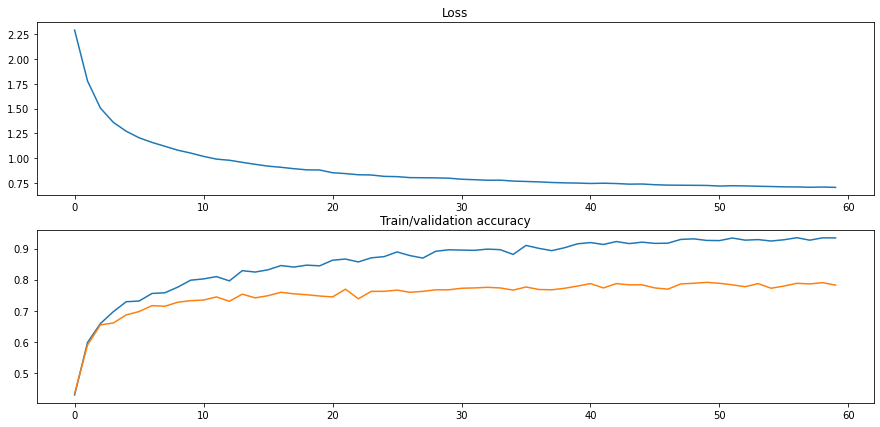

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.747000
